In [1]:
#import the packages
import pyspark
import os 
import pandas as pd
sc = pyspark.SparkContext()
sqlsc = pyspark.SQLContext(sc) #We will get a sql context, to speak in sql to spark
spark = sqlsc.sparkSession #Will send commands to spark

## Step 1 – Merging gas prices files

Read all prices files for 2016, 2017 and 2018 from csv file

In [2]:
price_16 = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('C:/Users/maure/OneDrive/Documents/S9/Big Data/Mignot/Projet/Prix2016.csv')
price_17 = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('C:/Users/maure/OneDrive/Documents/S9/Big Data/Mignot/Projet/Prix2017.csv')
price_18 = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('C:/Users/maure/OneDrive/Documents/S9/Big Data/Mignot/Projet/Prix20181114.csv')
#We ask him to read the data knowing the separator, that there are no headers and we want him to guess the data class

In [3]:
price_16.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: timestamp (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: integer (nullable = true)



In [4]:
#Number of rows
price_16.count()

3894247

Merge all prices files

In [5]:
price = price_16.union(price_17).union(price_18)

In [6]:
price.show(5) #show the top 5 rows

+-------+----+---+---------+--------+-------------------+---+------+----+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|
+-------+----+---+---------+--------+-------------------+---+------+----+
|1000001|1000|  R|4620114.0|519791.0|2016-01-02 09:01:58|  1|Gazole|1026|
|1000001|1000|  R|4620114.0|519791.0|2016-01-04 10:01:35|  1|Gazole|1026|
|1000001|1000|  R|4620114.0|519791.0|2016-01-04 12:01:15|  1|Gazole|1026|
|1000001|1000|  R|4620114.0|519791.0|2016-01-05 09:01:12|  1|Gazole|1026|
|1000001|1000|  R|4620114.0|519791.0|2016-01-07 08:01:13|  1|Gazole|1026|
+-------+----+---+---------+--------+-------------------+---+------+----+
only showing top 5 rows



Rename the column

In [7]:
price_ddf = price.selectExpr(
    '_c0 as id_station',
    '_c1 as code_postal',
    '_c2 as type_station',
    '_c3 as latitude',
    '_c4 as longitude',
    '_c5 as date_releve',
    '_c6 as type_carburant',
    '_c7 as libelle_carburant',
    '_c8/1000 as price'
)
price_ddf.printSchema()

root
 |-- id_station: integer (nullable = true)
 |-- code_postal: integer (nullable = true)
 |-- type_station: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date_releve: timestamp (nullable = true)
 |-- type_carburant: integer (nullable = true)
 |-- libelle_carburant: string (nullable = true)
 |-- price: double (nullable = true)



In [8]:
price_ddf.show(5) #Show the top 5 rows

+----------+-----------+------------+---------+---------+-------------------+--------------+-----------------+-----+
|id_station|code_postal|type_station| latitude|longitude|        date_releve|type_carburant|libelle_carburant|price|
+----------+-----------+------------+---------+---------+-------------------+--------------+-----------------+-----+
|   1000001|       1000|           R|4620114.0| 519791.0|2016-01-02 09:01:58|             1|           Gazole|1.026|
|   1000001|       1000|           R|4620114.0| 519791.0|2016-01-04 10:01:35|             1|           Gazole|1.026|
|   1000001|       1000|           R|4620114.0| 519791.0|2016-01-04 12:01:15|             1|           Gazole|1.026|
|   1000001|       1000|           R|4620114.0| 519791.0|2016-01-05 09:01:12|             1|           Gazole|1.026|
|   1000001|       1000|           R|4620114.0| 519791.0|2016-01-07 08:01:13|             1|           Gazole|1.026|
+----------+-----------+------------+---------+---------+-------

Split date in year, month, week of the year

In [9]:
spark = sqlsc.sparkSession

In [10]:
sqlsc.registerDataFrameAsTable(price_ddf,'price')
spark.sql(
    'SELECT id_station, code_postal , type_station, year(date_releve) as year, month(date_releve) as month , '
    'weekofyear(date_releve) as week,date_releve, type_carburant, libelle_carburant, price, latitude, longitude '
    'FROM price'
).show() #Show the table with the split date

+----------+-----------+------------+----+-----+----+-------------------+--------------+-----------------+-----+---------+---------+
|id_station|code_postal|type_station|year|month|week|        date_releve|type_carburant|libelle_carburant|price| latitude|longitude|
+----------+-----------+------------+----+-----+----+-------------------+--------------+-----------------+-----+---------+---------+
|   1000001|       1000|           R|2016|    1|  53|2016-01-02 09:01:58|             1|           Gazole|1.026|4620114.0| 519791.0|
|   1000001|       1000|           R|2016|    1|   1|2016-01-04 10:01:35|             1|           Gazole|1.026|4620114.0| 519791.0|
|   1000001|       1000|           R|2016|    1|   1|2016-01-04 12:01:15|             1|           Gazole|1.026|4620114.0| 519791.0|
|   1000001|       1000|           R|2016|    1|   1|2016-01-05 09:01:12|             1|           Gazole|1.026|4620114.0| 519791.0|
|   1000001|       1000|           R|2016|    1|   1|2016-01-07 08:01

Prepare latitude & longitude for mapping (divide by the right power of 10, which is 100000) 

In [11]:
spark.sql(
    'SELECT id_station, code_postal , type_station, year(date_releve) as year, month(date_releve) as month , '
    'weekofyear(date_releve) as week, type_carburant, libelle_carburant, price, latitude/100000 as lati, longitude/100000 as longi '
    'FROM price'
).show() #Show the table with the right latitude and longitude

+----------+-----------+------------+----+-----+----+--------------+-----------------+-----+--------+-------+
|id_station|code_postal|type_station|year|month|week|type_carburant|libelle_carburant|price|    lati|  longi|
+----------+-----------+------------+----+-----+----+--------------+-----------------+-----+--------+-------+
|   1000001|       1000|           R|2016|    1|  53|             1|           Gazole|1.026|46.20114|5.19791|
|   1000001|       1000|           R|2016|    1|   1|             1|           Gazole|1.026|46.20114|5.19791|
|   1000001|       1000|           R|2016|    1|   1|             1|           Gazole|1.026|46.20114|5.19791|
|   1000001|       1000|           R|2016|    1|   1|             1|           Gazole|1.026|46.20114|5.19791|
|   1000001|       1000|           R|2016|    1|   1|             1|           Gazole|1.026|46.20114|5.19791|
|   1000001|       1000|           R|2016|    1|   1|             1|           Gazole|1.029|46.20114|5.19791|
|   100000

Make data available as a table in order to be able to use Spark SQL

In [12]:
spark.sql(
    'SELECT id_station, code_postal , type_station, year(date_releve) as year, month(date_releve) as month , '
    'weekofyear(date_releve) as week, day(date_releve) as day, date_releve,type_carburant, libelle_carburant, price, latitude/100000 as latitude, longitude/100000 as longitude '
    'FROM price'
).cache().createOrReplaceTempView('price_mean_data')

In [13]:
price_mean=spark.sql(
    'SELECT id_station, code_postal , type_station, year(date_releve) as year, month(date_releve) as month , '
    'weekofyear(date_releve) as week, day(date_releve) as day, date_releve,type_carburant, libelle_carburant, price, latitude/100000 as latitude, longitude/100000 as longitude '
    'FROM price'
).cache()

In [14]:
sqlsc.registerDataFrameAsTable(price_mean,'price_mean') # Creation of a data avaible as a table

In [15]:
sqlsc.sql('SELECT count(*) as nb_releves FROM price_mean').show() #Show the number of releves

+----------+
|nb_releves|
+----------+
|  10884637|
+----------+



## Step 2  – Deduplicating stations

Read and merge all stations files (2016-2018) 

In [16]:
stations_16 = (spark.read.load('C:/Users/maure/OneDrive/Documents/S9/Big Data/Mignot/Projet/Stations2016.csv', format='csv', sep="|", header='false',inferSchema='true')
                    .selectExpr(
                    '_c0 as id_station',
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3/100000 as latitude',
                    '_c4/100000 as longitude',
                    '_c5 as adress',
                    '_c6 as city'
                ).cache())
stations_17 = (spark.read.load('C:/Users/maure/OneDrive/Documents/S9/Big Data/Mignot/Projet/Stations2017.csv', format='csv', sep="|", header='false',inferSchema='true')
                    .selectExpr(
                    '_c0 as id_station',
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3/100000 as latitude',
                    '_c4/100000 as longitude',
                    '_c5 as adress',
                    '_c6 as city'
                ).cache())
stations_18 = (spark.read.load('C:/Users/maure/OneDrive/Documents/S9/Big Data/Mignot/Projet/Stations2018.csv', format='csv', sep="|", header='false',inferSchema='true')
                    .selectExpr(
                    '_c0 as id_station',
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3/100000 as latitude',
                    '_c4/100000 as longitude',
                    '_c5 as adress',
                    '_c6 as city'
                ).cache())
stations_ddf = stations_16.union(stations_17).union(stations_18).dropna()
sqlsc.registerDataFrameAsTable(stations_ddf,'stations') # Creation of a data avaible as a table

In [17]:
stations_ddf.show(10) #Show the top 10 rows

+----------+-----------+------------+-------------+-----------------+--------------------+--------------------+
|id_station|code_postal|type_station|     latitude|        longitude|              adress|                city|
+----------+-----------+------------+-------------+-----------------+--------------------+--------------------+
|   1000001|       1000|           R|     46.20114|          5.19791|596 AVENUE DE TRE...|SAINT-DENIS-LèS-B...|
|   1000002|       1000|           R|     46.21842|          5.22767| 16 Avenue de Marboz|     BOURG-EN-BRESSE|
|   1000004|       1000|           R|     46.18836|          5.24447|20 Avenue du Maré...|     Bourg-en-Bresse|
|   1000005|       1000|           R|46.2009359235|    5.19942024022|642 Avenue de Tré...|SAINT-DENIS-LèS-B...|
|   1000006|       1000|           R|     46.20754|          5.23758|1 Boulevard John ...|     BOURG-EN-BRESSE|
|   1000007|       1000|           R|     46.20105|          5.24891|360 AVENUE DU CAP...|     Bourg-en-

Deduplicate stations based on location

In [18]:
#Group by stations by selected deduplication key(s)
sqlsc.registerDataFrameAsTable(stations_ddf, 'stations')
spark.sql(
    'SELECT *, concat(latitude,longitude) as localisation '
    'FROM stations '
    'ORDER BY localisation').cache().createOrReplaceTempView('station')

In [19]:
#Generate a unique ID
#Create a table with the unique ID
spark.sql(
    'SELECT distinct(localisation) , max(id_station) as ID, '
    'code_postal, type_station, adress, city, latitude, longitude '
    'FROM station '
    'GROUP BY localisation, code_postal, type_station, adress, city, latitude, longitude '
    'ORDER BY localisation'
    ).cache().createOrReplaceTempView('station_new')
spark.sql(
    'SELECT distinct(localisation), ID, adress, city, latitude,longitude '
    'FROM station_new '
    'ORDER BY localisation').cache().createOrReplaceTempView('id_ddf')

In [20]:
spark.sql('SELECT * FROM id_ddf').show(10) #Show the top 10 rows

+--------------------+--------+--------------------+--------------------+--------------------+--------------------+
|        localisation|      ID|              adress|                city|            latitude|           longitude|
+--------------------+--------+--------------------+--------------------+--------------------+--------------------+
|-0.4537850346.985...|79150001|Avenue Camille Jo...|Argenton-les-Vallées|         -0.45378503|  46.985288669999996|
|-1.00899999999999...|85500003|40, AVE GEORGES C...|        Les Herbiers|-1.00899999999999...|4.685799999999999...|
|-1.01600000000000...|53410003|      La Route Neuve|         LA GRAVELLE|-1.01600000000000...|4.807399999999999...|
|  -1.028E-54.5619E-4|17200007|   quai des sabliers|               Royan|           -1.028E-5|           4.5619E-4|
|-1.02999999999999...|14160002|Boulevard Maurice...|       DIVES-SUR-MER|-1.02999999999999...|           4.9284E-4|
|  -1.033E-54.8938E-4|14380002|     3 route de caen|          PONT-FARCY

In [21]:
#Generate a mapping table associating station id in the file with this unique ID
spark.sql(
    'SELECT station.localisation, station.id_station, id_ddf.ID, id_ddf.adress, '
    'station.city, station.latitude, station.longitude '
    'FROM station, id_ddf '
    'WHERE station.localisation = id_ddf.localisation and  station.longitude = id_ddf.longitude '
    'and station.latitude = id_ddf.latitude '
    'GROUP BY station.localisation, station.id_station, id_ddf.ID, station.longitude, station.latitude, '
    'id_ddf.adress, station.city'
    ).cache().createOrReplaceTempView('station_ID') # Creation of a data avaible as a table

Join this table to the price data for coming analysis

In [22]:
spark.sql('SELECT price_mean.id_station, price_mean.code_postal, price_mean.type_station, price_mean.latitude, '
          'price_mean.longitude, '
          'price_mean.year, price_mean.month, price_mean.week, price_mean.day, price_mean.date_releve, price_mean.type_carburant, '
          'price_mean.libelle_carburant, price_mean.price, station_ID.ID, station_ID.localisation '
          'FROM price_mean, station_ID '
          'WHERE price_mean.id_station = station_ID.id_station '
          'GROUP BY price_mean.id_station, price_mean.code_postal, price_mean.date_releve, price_mean.type_station, '
          'price_mean.latitude, price_mean.longitude, price_mean.year, price_mean.month, price_mean.week, price_mean.day, '
          'price_mean.type_carburant, price_mean.libelle_carburant, price_mean.price, station_ID.ID, station_ID.localisation'
         ).cache().createOrReplaceTempView('price2_data') 

In [23]:
price2=spark.sql('SELECT price_mean.id_station, price_mean.code_postal, price_mean.type_station, price_mean.latitude, '
          'price_mean.longitude, '
          'price_mean.year, price_mean.month, price_mean.week, price_mean.day, price_mean.date_releve, price_mean.type_carburant, '
          'price_mean.libelle_carburant, price_mean.price, station_ID.ID, station_ID.localisation '
          'FROM price_mean, station_ID '
          'WHERE price_mean.id_station = station_ID.id_station '
          'GROUP BY price_mean.id_station, price_mean.code_postal, price_mean.date_releve, price_mean.type_station, '
          'price_mean.latitude, price_mean.longitude, price_mean.year, price_mean.month, price_mean.week, price_mean.day, '
          'price_mean.type_carburant, price_mean.libelle_carburant, price_mean.price, station_ID.ID, station_ID.localisation'
         ).cache()

In [24]:
sqlsc.registerDataFrameAsTable(price2,'price2') # Creation of a data avaible as a table

# Step 3

Compute price index for each station per day

In [25]:
spark.sql('SELECT Avg(price) as average , day, month, year, date(date_releve) as date, libelle_carburant FROM price2 '
          'WHERE libelle_carburant is not null '
          'GROUP BY year, month, day, date, libelle_carburant '
         'ORDER BY year, month, day').cache().createOrReplaceTempView('daily_price')

In [26]:
spark.sql('SELECT price2.id_station, price2.code_postal, price2.type_station, price2.latitude, '
          'price2.longitude, daily_price.average , '
          'price2.year, price2.month, price2.week, price2.day, daily_price.date, price2.type_carburant, '
          'price2.libelle_carburant, price2.price, price2.ID, price2.localisation '
          'FROM price2 , daily_price '
          'WHERE price2.year=daily_price.year and price2.month=daily_price.month and price2.day=daily_price.day and price2.libelle_carburant=daily_price.libelle_carburant '
          'GROUP BY price2.id_station, price2.code_postal, price2.type_station, daily_price.date, '
          'price2.latitude, price2.longitude, price2.year, price2.month, price2.week, price2.day, '
          'price2.type_carburant, price2.libelle_carburant, price2.price, price2.ID, price2.localisation, daily_price.average'
         ).cache().createOrReplaceTempView('price2') #Creation of the table

In [27]:
spark.sql(' SELECT * , 100*(1+ (price-average)/average) as price_index '
         'FROM price2').cache().createOrReplaceTempView('total') # Creation of the price index

In [28]:
spark.sql('SELECT year, month, day , libelle_carburant , price_index FROM total ORDER BY year, month, day , libelle_carburant').show(10) #Show the top 10 rows

+----+-----+---+-----------------+------------------+
|year|month|day|libelle_carburant|       price_index|
+----+-----+---+-----------------+------------------+
|2016|    1|  1|              E10| 94.73993784036973|
|2016|    1|  1|              E10|106.39784651637913|
|2016|    1|  1|              E10| 96.29432566383767|
|2016|    1|  1|              E10|104.14398417235067|
|2016|    1|  1|              E10|108.80714764275442|
|2016|    1|  1|              E10|106.39784651637913|
|2016|    1|  1|              E10| 96.29432566383767|
|2016|    1|  1|              E10|  95.5171317521037|
|2016|    1|  1|              E10|  95.5171317521037|
|2016|    1|  1|              E10|104.14398417235067|
+----+-----+---+-----------------+------------------+
only showing top 10 rows



# Data Visualization (1/2)

In [29]:
#Import the packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
spark.sql('SELECT year, month, day , libelle_carburant , average FROM total ORDER BY year, month, day , libelle_carburant').show(10) #Show the top 10 rows

+----+-----+---+-----------------+------------------+
|year|month|day|libelle_carburant|           average|
+----+-----+---+-----------------+------------------+
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
|2016|    1|  1|              E10|1.2866801771117171|
+----+-----+---+-----------------+------------------+
only showing top 10 rows



Represent the daily evolution of average gas price over France

In [31]:
price_hebdo=spark.sql('SELECT DISTINCT libelle_carburant, average , date as date FROM price2 ' 
                      'ORDER BY date, libelle_carburant'
                     ).toPandas()

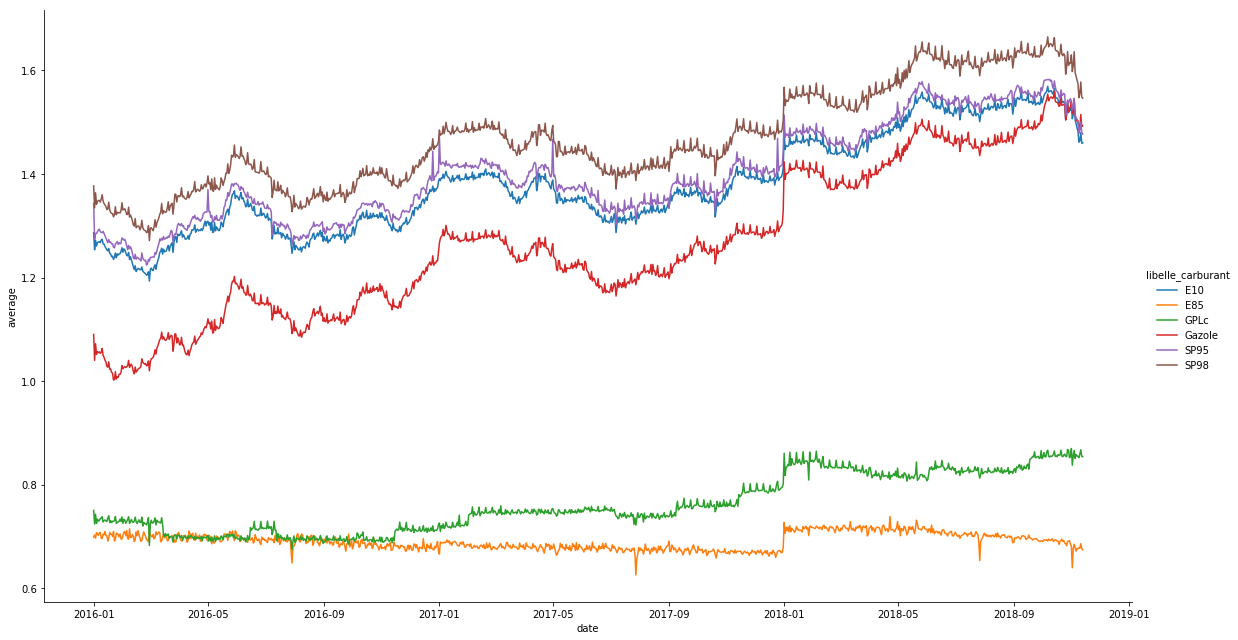

In [32]:
graph = sns.FacetGrid(price_hebdo.sort_values(by=['libelle_carburant','date']), hue='libelle_carburant',
                      height=9, aspect=16/9)
graph.map(plt.plot, "date", "average")
graph.add_legend()
#Graphic with the average price by type of gas dependinf on the date

# Data Visualization (2/2)

Compute average price index per gas type over departments

In [33]:
#Import package
import pygal.maps.fr

In [34]:
spark.sql('SELECT libelle_carburant, int(code_postal/1000) as dep , mean(price_index) as price_dep FROM total GROUP BY libelle_carburant, dep '
          'ORDER BY libelle_carburant, dep, price_dep').show(10) #Show the top 10 rows of the department

+-----------------+---+------------------+
|libelle_carburant|dep|         price_dep|
+-----------------+---+------------------+
|              E10|  1|100.81791733648522|
|              E10|  2|100.46333891223983|
|              E10|  3|   99.145338702983|
|              E10|  4|100.43617203305506|
|              E10|  5|100.35808835638572|
|              E10|  6|101.23725308012791|
|              E10|  7| 98.65025810201027|
|              E10|  8|100.77078898292514|
|              E10|  9| 98.49970284128537|
|              E10| 10|100.40896809718338|
+-----------------+---+------------------+
only showing top 10 rows



In [35]:
dep_df =spark.sql('SELECT libelle_carburant, int(code_postal/1000) as dep , mean(price_index) as price_dep '
                  'FROM total '
                  'GROUP BY libelle_carburant, dep '
                  'ORDER BY libelle_carburant, dep, price_dep'
                     ).toPandas() 

In [36]:
spark.sql('SELECT distinct(libelle_carburant) FROM total').show() #Show the name of the carburant

+-----------------+
|libelle_carburant|
+-----------------+
|              E10|
|             SP98|
|              E85|
|           Gazole|
|             SP95|
|             GPLc|
+-----------------+



Represent France department average price index heatmaps for each gas type

In [37]:
# E10
e10_df = dep_df.loc[dep_df['libelle_carburant'] == 'E10']
dict_e10 = e10_df.set_index('dep').to_dict()['price_dep']
e10_chart = pygal.maps.fr.Departments()
e10_chart.title = ' Carte du prix moyen de E10'
e10_chart.add('Prix_moyen', dict_e10 )
e10_chart.render_in_browser()

file://C:/Users/maure/AppData/Local/Temp/tmpd0mxt03l.html


In [38]:
# SP98
sp98_df = dep_df.loc[dep_df['libelle_carburant'] == 'SP98']
dict_sp98 = sp98_df.set_index('dep').to_dict()['price_dep']
sp98_chart = pygal.maps.fr.Departments()
sp98_chart.title = ' Carte du prix moyen de SP98'
sp98_chart.add('Prix_moyen', dict_sp98 )
sp98_chart.render_in_browser()

file://C:/Users/maure/AppData/Local/Temp/tmpm4mbhgeq.html


In [39]:
# E85
e85_df = dep_df.loc[dep_df['libelle_carburant'] == 'E85']
dict_e85 = e85_df.set_index('dep').to_dict()['price_dep']
e85_chart = pygal.maps.fr.Departments()
e85_chart.title = ' Carte du prix moyen de E85'
e85_chart.add('Prix_moyen', dict_e85 )
e85_chart.render_in_browser()

file://C:/Users/maure/AppData/Local/Temp/tmph3ji4tdy.html


In [40]:
# Gazole
gaz_df = dep_df.loc[dep_df['libelle_carburant'] == 'Gazole']
dict_gaz = gaz_df.set_index('dep').to_dict()['price_dep']
gaz_chart = pygal.maps.fr.Departments()
gaz_chart.title = ' Carte du prix moyen du Gazole'
gaz_chart.add('Prix_moyen', dict_gaz )
gaz_chart.render_in_browser()

file://C:/Users/maure/AppData/Local/Temp/tmpwq2jcybx.html


In [41]:
# SP95
sp95_df = dep_df.loc[dep_df['libelle_carburant'] == 'SP95']
dict_sp95 = sp95_df.set_index('dep').to_dict()['price_dep']
sp95_chart = pygal.maps.fr.Departments()
sp95_chart.title = ' Carte du prix moyen de SP95'
sp95_chart.add('Prix_moyen', dict_sp95 )
sp95_chart.render_in_browser()

file://C:/Users/maure/AppData/Local/Temp/tmpygnt623e.html


In [42]:
# GPLc
gplc_df = dep_df.loc[dep_df['libelle_carburant'] == 'GPLc']
dict_gplc = gplc_df.set_index('dep').to_dict()['price_dep']
gplc_chart = pygal.maps.fr.Departments()
gplc_chart.title = ' Carte du prix moyen de gplc'
gplc_chart.add('Prix_moyen', dict_gplc )
gplc_chart.render_in_browser()

file://C:/Users/maure/AppData/Local/Temp/tmpz0b0bf5l.html


# Modeling 1 – Option 1 – Forecast next day price

Build a model based on Spark MLlib to forecast the next day price for a gas type in a station 

In [43]:
#Import the package
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.pipeline import Pipeline
from sklearn import linear_model
regr=linear_model.LinearRegression()

In [44]:
lag_ddf=spark.sql('SELECT *, lag(price_index,1) OVER (ORDER BY ID, date, libelle_carburant) as lag_1, lag(price_index,2) OVER (ORDER BY ID, date, libelle_carburant) as lag_2, '
          'lag(price_index,3) OVER (ORDER BY ID, date, libelle_carburant) as lag_3, lag(price_index,4) OVER (ORDER BY ID, date, libelle_carburant) as lag_4 '
         'FROM total '
          'ORDER BY date, libelle_carburant'
         ).cache()

In [45]:
lag_ddf.show(5)

+----------+-----------+------------+-------------+-----------------+------------------+----+-----+----+---+----------+--------------+-----------------+-----+--------+--------------------+------------------+------------------+------------------+------------------+------------------+
|id_station|code_postal|type_station|     latitude|        longitude|           average|year|month|week|day|      date|type_carburant|libelle_carburant|price|      ID|        localisation|       price_index|             lag_1|             lag_2|             lag_3|             lag_4|
+----------+-----------+------------+-------------+-----------------+------------------+----+-----+----+---+----------+--------------+-----------------+-----+--------+--------------------+------------------+------------------+------------------+------------------+------------------+
|   1000008|       1000|           R|46.1994165092|     5.2407035676|1.2866801771117171|2016|    1|  53|  1|2016-01-01|             5|              

In [47]:
lag=lag_ddf.selectExpr('id_station as features', 'price_index')

In [48]:
lag.show(5)

+--------+------------------+
|features|       price_index|
+--------+------------------+
| 1000008|  95.5171317521037|
|95190005|102.74503513122953|
| 1000008|  95.5171317521037|
|95190005|102.74503513122953|
| 1000013| 96.29432566383767|
+--------+------------------+
only showing top 5 rows



In [49]:
lr=LinearRegression(labelCol='price_index')

In [50]:
regression=lr.fit(lag_ddf.selectExpr('id_station as features', 'price_index'))

IllegalArgumentException: 'requirement failed: Column features must be of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually int.'

In [51]:
regr.transform(lag_ddf.selectExpr('id_station', 'week', 'libelle_carburant', 'id_station as features', 'price_index')).show(5)

AttributeError: 'LinearRegression' object has no attribute 'transform'

In [52]:
#I didn't succeed the modeling part